In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from gammapy.irf import load_cta_irfs
from gammapy.maps import WcsGeom, MapAxis
from regions import CircleSkyRegion
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    GaussianSpatialModel,
    SkyModel,
    Models,
    PointSpatialModel,
    FoVBackgroundModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.makers import MapDatasetMaker, SafeMaskMaker, RingBackgroundMaker, FoVBackgroundMaker
from gammapy.modeling import Fit
from gammapy.maps import Map
from scipy.stats import norm
from gammapy.data import Observation
from gammapy.datasets import MapDataset, MapDatasetOnOff
from gammapy.estimators import ExcessMapEstimator

In [3]:
import scipy.stats as stats
import math
import statistics
import os

In [4]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [5]:
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


In [6]:
# Define the observation parameters (typically the observation duration and the pointing position):
livetime = 1.0 * u.hr
l = 0.05
pointing = SkyCoord(141.409467, 40.566962, unit="deg", frame="galactic")

In [7]:
# Define map geometry for binned simulation
energy_reco = MapAxis.from_edges(
    np.logspace(-1.0, 1.0, 10), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(141.409467, 40.566962),
    binsz=0.02,
    width=(3, 3),
    frame="galactic",
    axes=[energy_reco],
)
# It is usually useful to have a separate binning for the true energy axis
energy_true = MapAxis.from_edges(
    np.logspace(-1.5, 1.5, 30), unit="TeV", name="energy_true", interp="log"
)

empty = MapDataset.create(geom, name="dataset-simu")

In [8]:
# Define sky model to used simulate the data.
# Here we use a Gaussian spatial model and a Power Law spectral model.
spatial_model = PointSpatialModel(
    lon_0="141.409467 deg", lat_0="40.566962 deg", frame="galactic"
)
spectral_model = PowerLawSpectralModel(
    index=2.22, amplitude="1.289e-12 cm-2 s-1 TeV-1", reference="1 TeV"
)
model_simu = SkyModel(
    spatial_model=spatial_model,
    spectral_model=spectral_model,
    name="model-simu",
)

bkg_model = FoVBackgroundModel(dataset_name="dataset-simu")

models = Models([model_simu, bkg_model])
print(models)

Models

Component 0: SkyModel

  Name                      : model-simu
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :   2.220              
    amplitude               :   1.29e-12  1 / (cm2 s TeV)
    reference    (frozen)   :   1.000  TeV         
    lon_0                   : 141.409  deg         
    lat_0                   :  40.567  deg         

Component 1: FoVBackgroundModel

  Name                      : dataset-simu-bkg
  Datasets names            : ['dataset-simu']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                    :   1.000              
    tilt         (frozen)   :   0.000              
    reference    (frozen)   :   1.000  TeV         




In [9]:
def de(energy_reco, energy_true, livetime, irfs, pointing, geom, models):
    model = models.copy()
    
    obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
    maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])
    maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=3.5 * u.deg)
    dataset = maker.run(empty, obs)
    dataset = maker_safe_mask.run(dataset, obs)
    dataset.models = model
    dataset.fake(random_state=42)
    
    geom_image = geom.to_image().to_cube([energy_reco.squash()])
    regions = CircleSkyRegion(center=pointing, radius=0.2 * u.deg)
    exclusion_mask = Map.from_geom(geom_image)
    exclusion_mask.data = geom_image.region_mask([regions], inside=False)
    maker_fov = FoVBackgroundMaker(method="fit", exclusion_mask=exclusion_mask)
    dataset = maker_fov.run(dataset)
    
    TS0 = dataset.stat_sum()
    models_fit = model.copy()
    dataset.models = models_fit
    fit = Fit([dataset])
    result = fit.run()
    print(result)
    TS1 = dataset.stat_sum()
    del_TS = TS1 - TS0
    
    return del_TS

In [10]:
def de1(energy_reco, energy_true, livetime, irfs, pointing, geom, models):
    model = models.copy()
    
    obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
    maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])
    maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=3.5 * u.deg)
    dataset = maker.run(empty, obs)
    dataset = maker_safe_mask.run(dataset, obs)
    dataset.models = model
    dataset.fake(random_state=42)
    
    geom_image = geom.to_image().to_cube([energy_reco.squash()])
    regions = CircleSkyRegion(center=pointing, radius=0.2 * u.deg)
    exclusion_mask = Map.from_geom(geom_image)
    exclusion_mask.data = geom_image.region_mask([regions], inside=False)
    ring_maker = RingBackgroundMaker(
        r_in="0.5 deg", width="0.3 deg", exclusion_mask=exclusion_mask
    )
    dataset_on_off = MapDatasetOnOff.create(
        geom=geom_image, energy_axis_true=energy_true, name="stacked"
    )
    dataset_on_off = ring_maker.run(dataset.to_image())
    
    TS0 = dataset_on_off.stat_sum()########
    dataset_on_off.models = model
    fit = Fit([dataset_on_off])
    result = fit.run()
    print(result)
    TS1 = dataset_on_off.stat_sum()
    del_TS = TS1 - TS0
    
    return del_TS

In [11]:
def de2(energy_reco, energy_true, livetime, irfs, pointing, geom, models):
    model = models.copy()
    obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
    maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])
    maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=3.5 * u.deg)
    dataset = maker.run(empty, obs)
    dataset = maker_safe_mask.run(dataset, obs)
    dataset.models = model
    dataset.fake(random_state=42)
    
    geom_image = geom.to_image().to_cube([energy_reco.squash()])
    regions = CircleSkyRegion(center=pointing, radius=0.2 * u.deg)
    exclusion_mask = Map.from_geom(geom_image)
    exclusion_mask.data = geom_image.region_mask([regions], inside=False)
    ring_maker = RingBackgroundMaker(
        r_in="0.5 deg", width="0.3 deg", exclusion_mask=exclusion_mask
    )
    dataset_on_off = MapDatasetOnOff.create(
        geom=geom_image, energy_axis_true=energy_true, name="stacked"
    )
    dataset_on_off = ring_maker.run(dataset.to_image())
    
    
    dataset_on_off.models = model#########
    TS0 = dataset_on_off.stat_sum()
    fit = Fit([dataset_on_off])
    result = fit.run()
    print(result)
    TS1 = dataset_on_off.stat_sum()
    del_TS = TS1 - TS0
    
    return del_TS

In [12]:
x = [1.0,5.0,10.0,25.0,50.0] * u.hr
y1 = []
y2 = []
y3 = []

In [13]:
for i in range(len(x)):
    print("live time:", x[i])
    y1.append(de(energy_reco, energy_true, x[i], irfs, pointing, geom, models))
    y2.append(de1(energy_reco, energy_true, x[i], irfs, pointing, geom, model_simu))
    y3.append(de2(energy_reco, energy_true, x[i], irfs, pointing, geom, model_simu))

live time: 1.0 h
OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 118
	total stat : 116586.13

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 101
	total stat : 25817.92

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 101
	total stat : 25817.92

live time: 5.0 h
OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 120
	total stat : 144140.66

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 79
	total stat : 23421.41

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization termin

In [14]:
print(y1)
print(y2)
print(y3)

[-2.3882941227784613, -3.9325871435867157, -2.3162973263533786, -6.474244020879269, -2.300196336582303]
[-346.56392897927435, -1577.046948822448, -3562.131316813873, -8570.88969078823, -16290.711790776812]
[-0.7000685572711518, -1.6496406296500936, -2.7697249074699357, -6.6257173591293395, -4.122639950830489]


Text(0.5, 1.0, 'FoV_background')

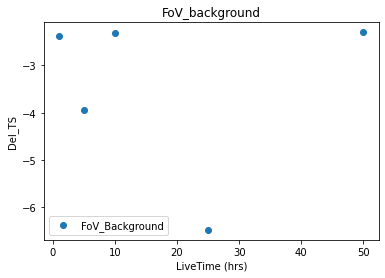

In [15]:
plt.scatter(x,y1)
#plt.xscale("log")
plt.legend(["FoV_Background"])
plt.ylabel("Del_TS")
plt.xlabel("LiveTime (hrs)")
plt.title("FoV_background")

Text(0.5, 1.0, 'Ring_background')

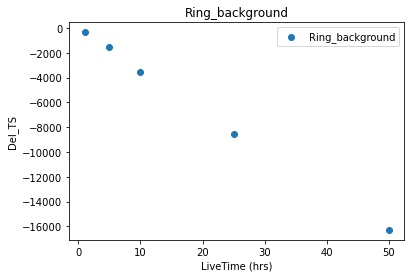

In [16]:
plt.scatter(x,y2)
#plt.xscale("log")
plt.legend(["Ring_background"])
plt.ylabel("Del_TS")
plt.xlabel("LiveTime (hrs)")
plt.title("Ring_background")

Text(0.5, 1.0, 'Ring_background')

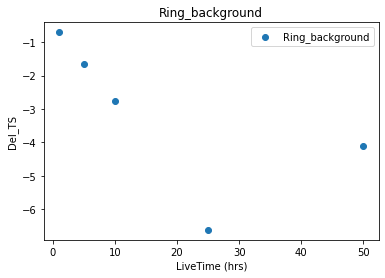

In [17]:
plt.scatter(x,y3)
#plt.xscale("log")
plt.legend(["Ring_background"])
plt.ylabel("Del_TS")
plt.xlabel("LiveTime (hrs)")
plt.title("Ring_background")